In [7]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

In [8]:
gas = ct.Solution("seiser.cti")  # Change .cti file to standard simple reaction
# gas = ct.Solution("2S_methane.cti")
# gas.Y = np.array([0.5, 0, 0.5, 0, 0])
gas.TP = 1200, 101325
reactor = ct.IdealGasReactor(gas)
sim = ct.ReactorNet([reactor])
# sim.advance(5.93e-6)
#gas.Y = np.array([0.25, 0.25, 0.25, 0.25, 0, 0])
gas.Y = np.ones(gas.n_species) / gas.n_species
# gas.set_equivalence_ratio(phi=1.0, fuel='nc7h16', oxidizer={'o2':1.0, 'n2':3.76})
np.save(".npy files/ini_mass_fraction.npy", gas.Y)
gas()



**** WARNING ****
For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.8343
	Value computed using high-temperature polynomial: 21.767

  gas:

       temperature            1200  K
          pressure         76289.4  Pa
           density        0.284491  kg/m^3
  mean mol. weight         37.2066  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      4.1341e+06        1.538e+08     J
   internal energy      3.8659e+06        1.438e+08     J
           entropy           10748        3.999e+05     J/K
    Gibbs function     -8.7633e+06       -3.261e+08     J
 heat capacity c_p          3280.6        1.221e+05     J/K
 heat capacity c_v          3057.2        1.137e+05     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                n2     0.00

In [38]:
gas.density

0.28449082923837005

In [41]:
#gas.TP = 1200, 101325
#gas.set_equivalence_ratio(phi=1.0, fuel='nc7h16', oxidizer={'o2':1.0, 'n2':3.76})
reactor = ct.IdealGasReactor(gas)
sim = ct.ReactorNet([reactor])
n_t = 200
Pt = np.zeros(n_t)
Tt = np.zeros(n_t)
Yt = np.zeros((gas.n_species,n_t))
Rhot = np.zeros(n_t) # New array for changing density of gases, representing incoming mass flux
for i in range(n_t):
    sim.advance((i+1)*1e-14)
    Pt[i] = gas.P
    Tt[i] = gas.T
    Yt[:,i] = gas.Y
    Rhot[i] = gas.density
    gas.density = gas.density + 1
    # print(nozzle_nasa_mdot((i+1)*1e-14))
gas()
# gas.density

AttributeError: attribute 'density' of 'cantera._cantera.ThermoPhase' objects is not writable

In [8]:
Pt

array([101346.95739854, 101368.45910547, 101389.51563926, 101410.13727787,
       101430.33408094, 101450.11589669, 101469.49235212, 101488.47286349,
       101507.06664343, 101525.28270347, 101543.12985752, 101560.61671527,
       101577.75170078, 101594.54304943, 101610.99881168, 101627.12685727,
       101642.9348774 , 101658.4303887 , 101673.62073679, 101688.51309873,
       101703.11448872, 101717.43176129, 101731.47160607, 101745.24056338,
       101758.74502075, 101771.99121987, 101784.98525651, 101797.73308368,
       101810.24051474, 101822.51322617, 101834.55676174, 101846.37653473,
       101857.97783092, 101869.36581106, 101880.54551485, 101891.52186036,
       101902.2996526 , 101912.88357796, 101923.27821509, 101933.48803129,
       101943.51738723, 101953.37053989, 101963.05164347, 101972.56475318,
       101981.91382643, 101991.10272615, 102000.13522169, 102009.01499229,
       102017.74562832, 102026.33063318, 102034.7734264 , 102043.07734388,
       102051.24564182, 1

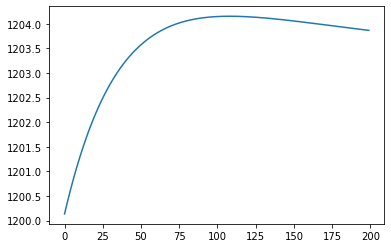

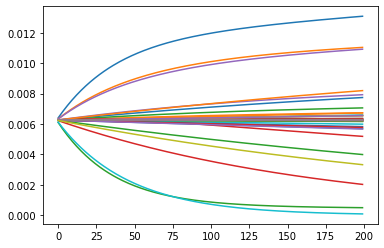

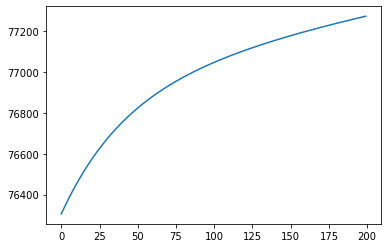

In [35]:
plt.plot(Tt)
plt.figure()
# plt.plot(Tt)
for i in range(gas.n_species):
    plt.plot(Yt[i,:])

plt.figure()
plt.plot(Pt)
####

In [11]:
np.save('.npy files/pressure.npy', Pt)
np.save('.npy files/temperature.npy', Tt)
np.save('.npy files/mass_fraction.npy', Yt)

In [12]:
tbd = []
falofr = []
elmr = []
for i in range(gas.n_reactions):
    if (isinstance(gas.reaction(i), ct.ThreeBodyReaction)):
        tbd.append(i)
    elif (isinstance(gas.reaction(i), ct.FalloffReaction)):
        falofr.append(i)
    else:
        elmr.append(i)

In [13]:
NASA_coeffs = []
for i in range(gas.n_species):
    NASA_coeffs.append(gas.species(i).thermo.coeffs)
NASA_coeffs = np.array(NASA_coeffs)
reactants = []
orders = [] 
Af = np.zeros(len(elmr))
beta = np.zeros(len(elmr))
E = np.zeros(len(elmr))

In [14]:
rec2ind = dict()
for i in range(gas.n_species):
    reactants.append(gas.species(i).name)
    rec2ind[gas.species(i).name] = i
orders = gas.reactant_stoich_coeffs()[:,elmr]
for i, s in enumerate(elmr):   
    Af[i] = gas.reaction(s).rate.pre_exponential_factor
    beta[i] = gas.reaction(s).rate.temperature_exponent
    E[i] = gas.reaction(s).rate.activation_energy
    for rec in gas.reaction(s).orders:
        orders[rec2ind[rec], i] = gas.reaction(s).orders[rec]
reversible = np.array([int(gas.reaction(i).reversible) for i in range(gas.n_reactions)])

In [15]:
np.save('.npy files/NASA_coeffs.npy', NASA_coeffs)
np.save('.npy files/molecular_weights.npy',gas.molecular_weights)
np.save('.npy files/reactants_stoich_coeffs.npy',gas.reactant_stoich_coeffs())
np.save('.npy files/product_stoich_coeffs.npy',gas.product_stoich_coeffs())
np.save('.npy files/reaction_orders.npy',orders)
np.save('.npy files/pre_exponential_factor.npy', Af)
np.save('.npy files/temperature_exponent.npy', beta)
np.save('.npy files/activation_energy.npy', E)
np.save('.npy files/delta_standard_entropy.npy', gas.delta_standard_entropy)
np.save('.npy files/delta_standard_enthalpy.npy', gas.delta_standard_enthalpy)
np.save('.npy files/reversible.npy', reversible)

In [16]:
efficiency_f = np.zeros((gas.n_species, len(falofr)))
Af_lo = np.zeros(len(falofr))
beta_lo = np.zeros(len(falofr))
E_lo = np.zeros(len(falofr))
Af_hi = np.zeros(len(falofr))
beta_hi = np.zeros(len(falofr))
E_hi = np.zeros(len(falofr))
orders_f = gas.reactant_stoich_coeffs()[:,falofr]
falloff_parameters = np.zeros((4, len(falofr)))
troefall = []
troefall_coeff = []
for i, s in enumerate(falofr):
    rr = gas.reaction(s)
    Af_lo[i] = rr.low_rate.pre_exponential_factor
    beta_lo[i] = rr.low_rate.temperature_exponent
    E_lo[i] = rr.low_rate.activation_energy
    Af_hi[i] = rr.high_rate.pre_exponential_factor
    beta_hi[i] = rr.high_rate.temperature_exponent
    E_hi[i] = rr.high_rate.activation_energy
    efficiency_f[:,i] = rr.default_efficiency * np.ones(gas.n_species)
    if(isinstance(rr.falloff, ct.TroeFalloff)):
        troefall.append(i)
        troefall_coeff.append(rr.falloff.parameters)
    #falloff_parameters[:,i] = gas.reaction(s).falloff.parameters
    for rec in rr.efficiencies:
        efficiency_f[rec2ind[rec]] = rr.efficiencies[rec]
    for rec in gas.reaction(s).orders:
        orders_f[rec2ind[rec], i] = gas.reaction(s).orders[rec]

np.save('.npy files/efficiency_f.npy', efficiency_f)
np.save('.npy files/troefall_coeff.npy', np.array(troefall_coeff).T)
np.save('.npy files/troefall.npy', troefall)
np.save('.npy files/reaction_orders_f.npy',orders_f)
np.save('.npy files/pre_exponential_factor_hi.npy', Af_hi)
np.save('.npy files/temperature_exponent_hi.npy', beta_hi)
np.save('.npy files/activation_energy_hi.npy', E_hi)
np.save('.npy files/pre_exponential_factor_lo.npy', Af_lo)
np.save('.npy files/temperature_exponent_lo.npy', beta_lo)
np.save('.npy files/activation_energy_lo.npy', E_lo)

In [17]:
efficiency_t = np.zeros((gas.n_species, len(tbd)))
Af_t = np.zeros(len(tbd))
beta_t = np.zeros(len(tbd))
E_t = np.zeros(len(tbd))
orders_t = gas.reactant_stoich_coeffs()[:,tbd]
for i, s in enumerate(tbd):
    rr = gas.reaction(s)
    Af_t[i] = rr.rate.pre_exponential_factor
    beta_t[i] = rr.rate.temperature_exponent
    E_t[i] = rr.rate.activation_energy
    efficiency_t[:,i] = rr.default_efficiency * np.ones(gas.n_species)
    for rec in rr.efficiencies:
        efficiency_t[rec2ind[rec]] = rr.efficiencies[rec]
    for rec in gas.reaction(s).orders:
        orders_t[rec2ind[rec], i] = gas.reaction(s).orders[rec]
        
np.save('.npy files/efficiency_t.npy',efficiency_t)
np.save('.npy files/reaction_orders_t.npy',orders_t)
np.save('.npy files/pre_exponential_factor_t.npy', Af_t)
np.save('.npy files/temperature_exponent_t.npy', beta_t)
np.save('.npy files/activation_energy_t.npy', E_t)

In [18]:
np.save('.npy files/tbd.npy',tbd)
np.save('.npy files/falofr.npy',falofr)
np.save('.npy files/elmr.npy',elmr)

In [19]:
ai = gas.reaction(0).high_rate.pre_exponential_factor
bi = gas.reaction(0).high_rate.temperature_exponent
ei = gas.reaction(0).high_rate.activation_energy
kf_h = ai * (gas.T**bi) * np.exp(-ei/(ct.gas_constant * gas.T))
kf_h

125366893824.50568

In [20]:
ai = gas.reaction(0).low_rate.pre_exponential_factor
bi = gas.reaction(0).low_rate.temperature_exponent
ei = gas.reaction(0).low_rate.activation_energy
kf_o = ai * (gas.T**bi) * np.exp(-ei/(ct.gas_constant * gas.T)) * gas.concentrations.dot(efficiency_f[:,0])
kf_o

5969920856.355112

In [21]:
kf_o / (1 + kf_o / kf_h)

5698557833.597583

In [23]:
np.array(troefall_coeff).shape

(20, 4)

In [22]:
help(gas.reaction(0).falloff)

Help on TroeFalloff object:

class TroeFalloff(Falloff)
 |  The 3- or 4-parameter Troe falloff function.
 |  
 |  :param params:
 |      An array of 3 or 4 parameters: :math:`[a, T^{***}, T^*, T^{**}]` where
 |      the final parameter is optional (with a default value of 0).
 |  
 |  Method resolution order:
 |      TroeFalloff
 |      Falloff
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __reduce__ = __reduce_cython__(...)
 |      TroeFalloff.__reduce_cython__(self)
 |  
 |  __setstate__ = __setstate_cython__(...)
 |      TroeFalloff.__setstate_cython__(self, __pyx_state)
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  falloff_type = 110
 | 

In [17]:
# gas.reaction().falloff.parameters

In [24]:
A = gas.reaction(falofr[10]).falloff.parameters
T = 1
A[0] + A[1] * T**3 + A[2] * T + A[3] * T**2

IndexError: index 0 is out of bounds for axis 0 with size 0

In [25]:
gas.reaction(falofr[1]).falloff

In [26]:
def nozzle_nasa_mdot(t):
    # Can represent mass inflow by increasing combined gas's density
    """
    Compute the efflux of the combustor via simple isentropic relations.
    The efficiency of the nozzle is modeled using a discharge coefficient
    :param t: time
    :return: mass flux at the outlet (efflux) of the combustion chamber.
    """
    # Avoid a unity pressure ratio at startup
    # print(gas.T)
    epsilon = 1.0
    _rho = gas.density
    _press = gas.P
    _area = 1  # arbitrarily chosen value, [m^2]
    _gamma_s = gas.cp / gas.cv
    _temp = gas.T
    _r_gas_specific = gas.cp - gas.cv
    _p_ratio = 101325 / (gas.P + epsilon)  # Exhaust pressure is atmospheric pressure

    power_1 = 2.0 / _gamma_s
    power_2 = (_gamma_s + 1.0) / (_gamma_s)
    pressure_term = _p_ratio ** power_1 - _p_ratio ** power_2
    _sqrt_term = 2. * _gamma_s * _r_gas_specific * _temp / (_gamma_s - 1.0)
    _sqrt_term *= pressure_term
    _sqrt_term = -_sqrt_term  # Just for debugging
    assert (_sqrt_term >= 0.0)
    _sqrt_term = np.sqrt(_sqrt_term)

    _mdot_unchoked = _rho * _area * _sqrt_term

    power = (_gamma_s + 1.0) / (_gamma_s - 1.0)
    _gamma_term = (2. / (_gamma_s + 1.0)) ** power
    _sqrt = np.sqrt(_gamma_s * _r_gas_specific * _temp * _gamma_term)
    _mdot_choked = _rho * _area * _sqrt

    _mdot = 0.0
    _p_crit_downstream = _press * (2. / (_gamma_s + 1.0)) ** (_gamma_s / (_gamma_s - 1.0))

    if _p_crit_downstream < 101325:  # Less than exhaust pressure = P_atm
        # Unchoked conditions
        _mdot = _mdot_unchoked
    else:
        # Choked conditions
        _mdot = _mdot_choked

    return _mdot  # * _geom_nozzle['C_d']  # Discharge coefficient

1203.863561162995
1203.859734122193
1203.8559191431452
1203.8521165405857
1203.8483266154963
1203.8445496556517
1203.8407859377526
1203.8370357285255
1203.8332992833848
1203.8295768464416
1203.8258686515087
1203.822174922704
1203.818495874627
1203.8148317125758
1203.8111826325562
1203.8075488218176
1203.8039304588463
1203.8003277136934
1203.796740748662
1203.793169717677
1203.7896147674467
1203.7860760371295
1203.7825536585165
1203.7790477567055
1203.77555844966
1203.7720858489224
1203.7686300597493
1203.765191180808
1203.761769305142
1203.7583645195878
1203.7549769055893
1203.7516065389052
1203.7482534900735
1203.7449178244008
1203.7415996021793
1203.7382988788124
1203.7350157049643
1203.7317501267046
1203.7285021856555
1203.725271919107
1203.722059360202
1203.7188645380472
1203.715687477707
1203.7125282006198
1203.7093867245092
1203.706263063317
1203.7031572278236
1203.7000692253619
1203.696999059827
1203.6939467322456
1203.690912240489
1203.6878955793734
1203.6848967410447
1203.6819

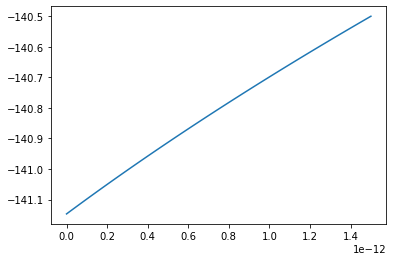

In [27]:
t = np.arange(0, 1.5*10**(-12), 1.5*10**(-14))
_mdot = np.zeros(len(t))

reactor = ct.IdealGasReactor(gas)  # Need to re-initialize reactor before running sim
sim = ct.ReactorNet([reactor])

for i in range(len(t)):
    sim.advance((i)*1e-14)
    _mdot[i] = nozzle_nasa_mdot(t[i])
    print(gas.T)
    
    
# print(t.shape) 
# print(_mdot.shape)
# plt.plot(t, _mdot)
plt.plot(t, -_mdot)  # For debugging

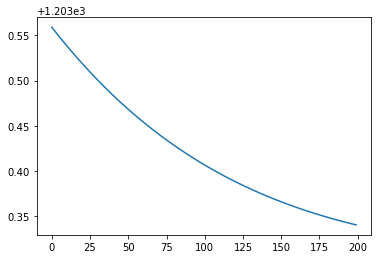

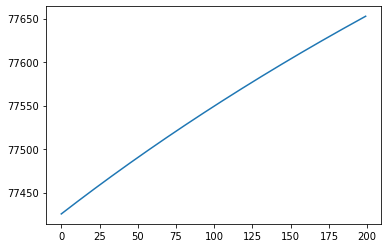

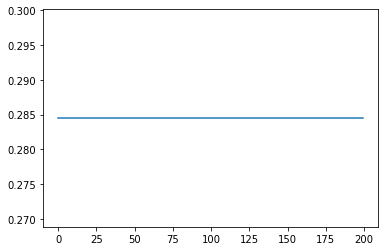

In [40]:
plt.plot(Tt)
plt.figure()
plt.plot(Pt)
plt.figure()
plt.plot(Rhot)
####